In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

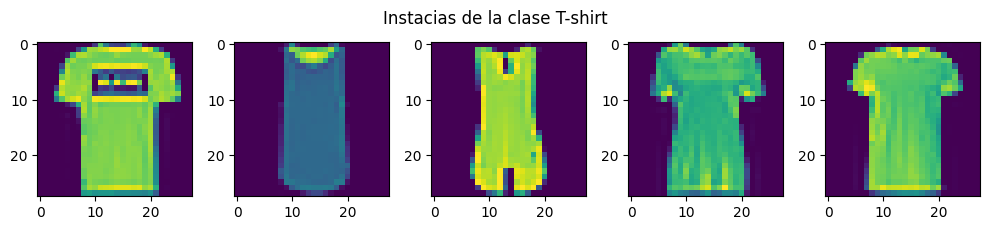

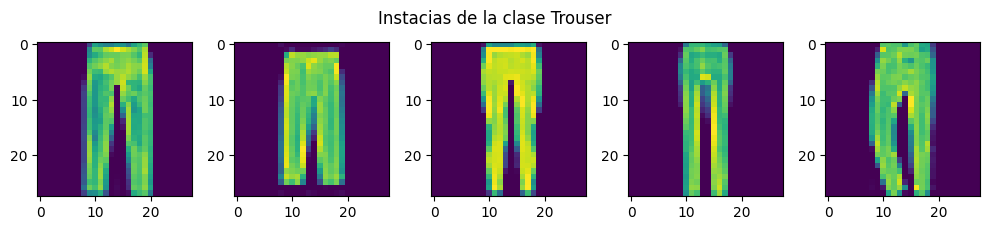

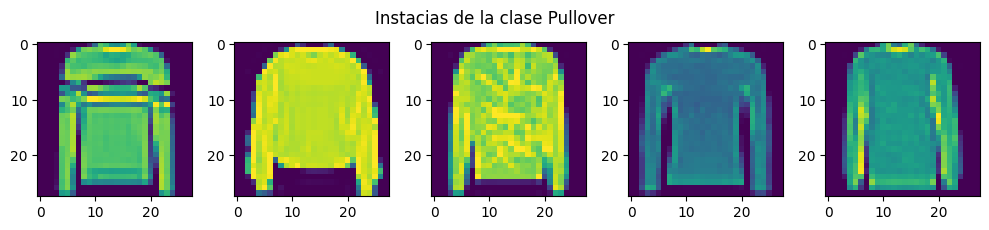

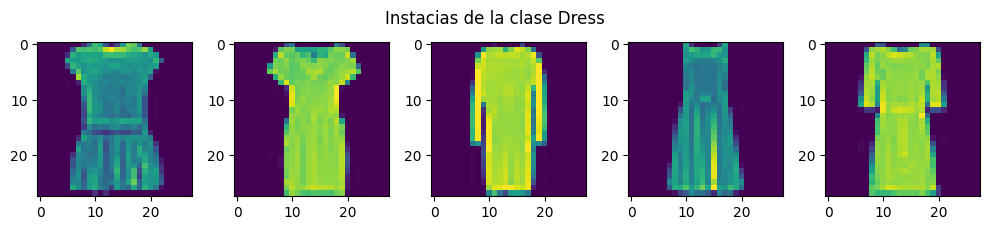

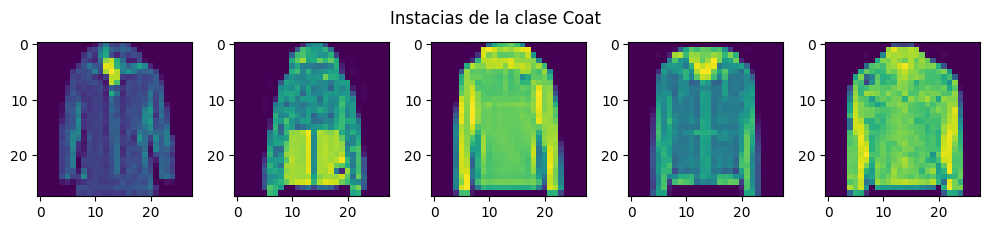

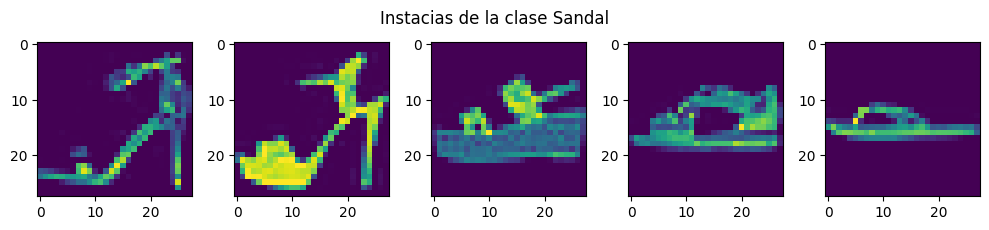

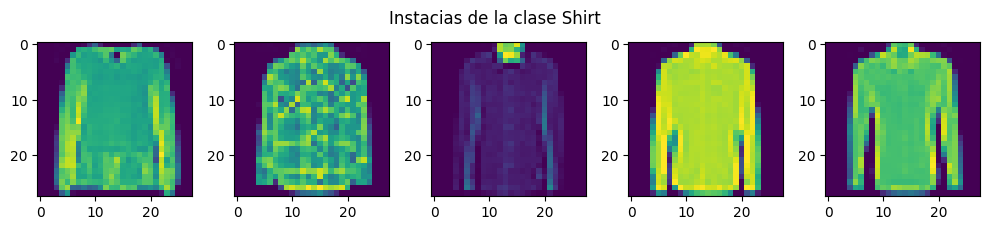

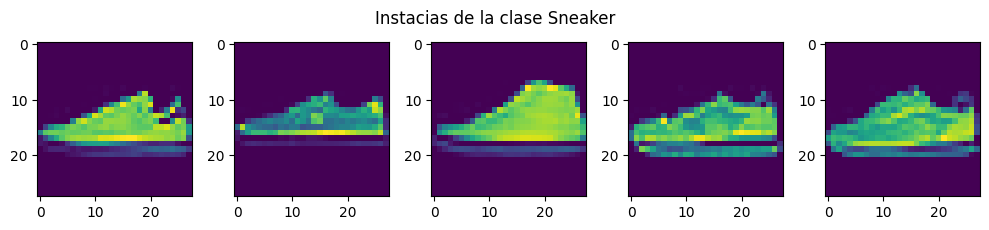

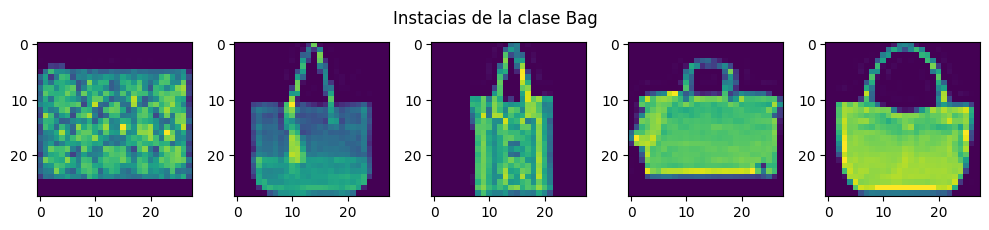

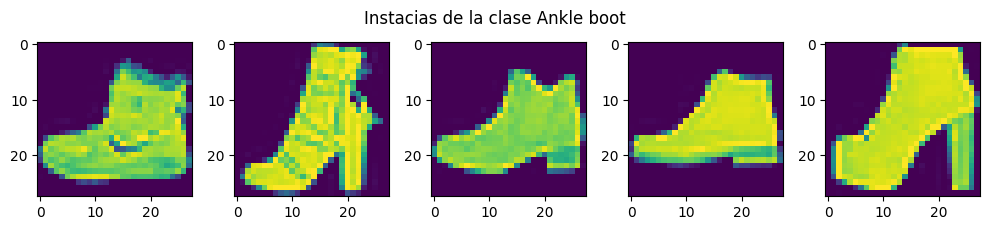

In [3]:
data = np.load('Data/train_images.npy')
labels = pd.read_csv('Data/train_labels.csv')

clases = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 2.3))
    for j in range(5): 
        ax[j].imshow(data[labels.label.values == i,...][j])

    fig.tight_layout()

    fig.suptitle('Instacias de la clase ' + clases[i])
    plt.show()

    

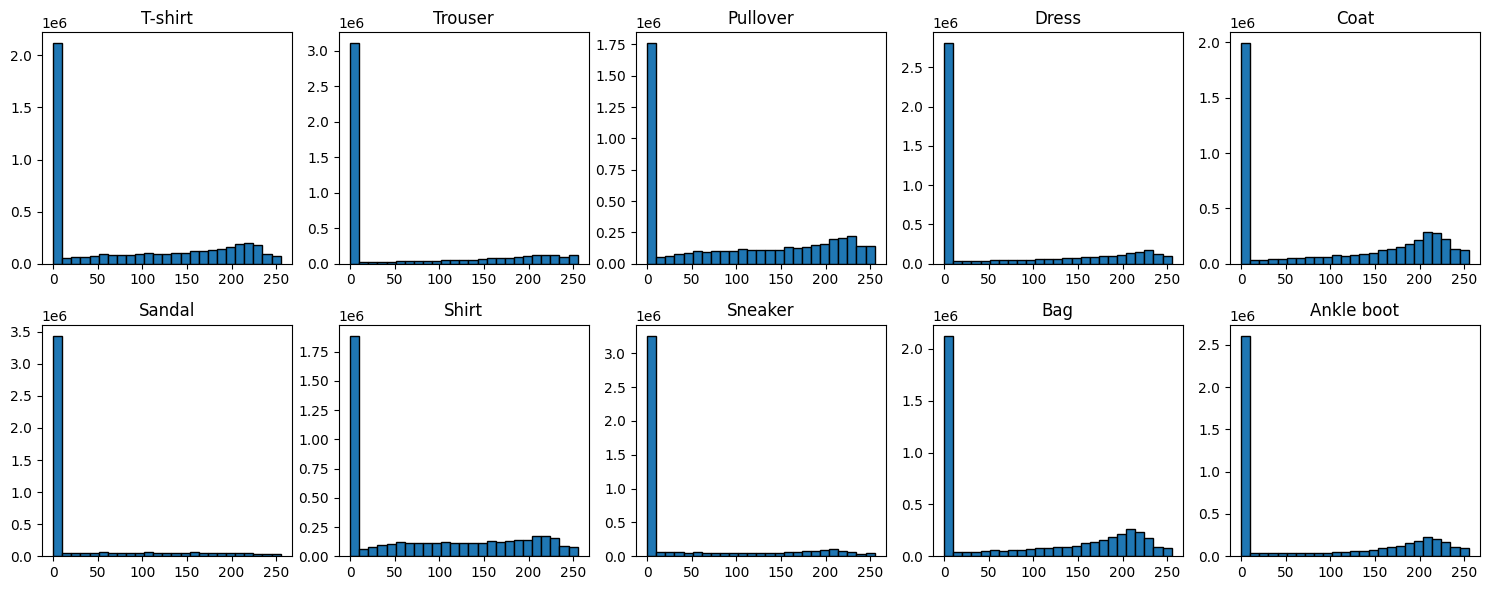

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(5):
    ax[0, i].hist(data[labels.label.values == i,...].flatten(), 25, edgecolor='k')
    ax[0, i].set_title(clases[i])
    
for i in range(5):
    ax[1, i].hist(data[labels.label.values == (i+5),...].flatten(), 25, edgecolor='k')
    ax[1, i].set_title(clases[i+5])

fig.tight_layout()

plt.show()

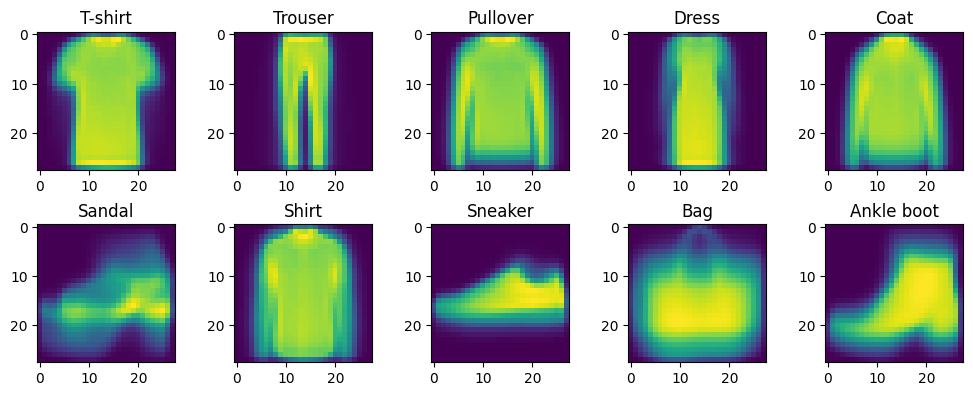

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

for i in range(5):
    ax[0, i].imshow(data[labels.label.values == i,...].mean(axis = 0))
    ax[0, i].set_title(clases[i])
    
for i in range(5):
    ax[1, i].imshow(data[labels.label.values == (i+5),...].mean(axis = 0))
    ax[1, i].set_title(clases[i+5])

fig.tight_layout()

plt.show()

In [6]:
labelsNp = np.array([int(i[0]) for i in labels.values.tolist() if i[0] != 'label'])
labelsNp

array([9, 0, 0, ..., 3, 0, 5])

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
trainX, testX, trainY, testY = train_test_split(data, labelsNp, test_size=0.25, random_state=42)

sparseTrainY = np.zeros([len(trainY), 10])
for idx in range(len(trainY)):
    sparseTrainY[idx, trainY[idx]] = 1

sparseTestY = np.zeros([len(testY), 10])
for idx in range(len(testY)):
    sparseTestY[idx, testY[idx]] = 1
    
trainX = trainX.astype(np.float32)/255
testX = testX.astype(np.float32)/255

In [9]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, Nadam, Adamax, Adagrad
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.initializers import Constant, GlorotNormal, GlorotUniform, Zeros, RandomNormal, glorot_uniform, zeros, random_normal, constant
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflowaddons

In [137]:
softmax = Sequential()

softmax.add(Flatten(input_shape=(28, 28)))
softmax.add(Dense(10, activation='softmax'))

softmax.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 dense_72 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [10]:
softmax.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy", Precision(), Recall()])
history = softmax.fit(x = trainX, y = sparseTrainY, validation_data = (testX, sparseTestY), epochs = 20, batch_size = 128)
name = 'base1'

Epoch 1/20
352/352 [==============================] - 3s 5ms/step - loss: 48.9402 - accuracy: 0.7445 - precision: 0.7445 - recall: 0.7445 - val_loss: 37.7295 - val_accuracy: 0.7635 - val_precision: 0.7635 - val_recall: 0.7635
Epoch 2/20
352/352 [==============================] - 1s 4ms/step - loss: 31.5575 - accuracy: 0.7850 - precision: 0.7850 - recall: 0.7850 - val_loss: 23.9971 - val_accuracy: 0.8105 - val_precision: 0.8105 - val_recall: 0.8105
Epoch 3/20
352/352 [==============================] - 1s 4ms/step - loss: 34.1886 - accuracy: 0.7928 - precision: 0.7928 - recall: 0.7928 - val_loss: 32.0263 - val_accuracy: 0.7963 - val_precision: 0.7963 - val_recall: 0.7962
Epoch 4/20
352/352 [==============================] - 1s 4ms/step - loss: 36.2432 - accuracy: 0.7934 - precision: 0.7935 - recall: 0.7934 - val_loss: 30.5239 - val_accuracy: 0.8129 - val_precision: 0.8130 - val_recall: 0.8129
Epoch 5/20
352/352 [==============================] - 1s 4ms/step - loss: 34.7618 - accuracy: 0.

In [11]:
predict = softmax.predict(testX)
argmaxPredict = np.argmax(predict, axis=1)
f1Macro = f1_score(testY, argmaxPredict, average='macro')
f1Macro

469/469 [==============================] - 1s 2ms/step


0.7490577357570177

In [12]:
areaROC = roc_auc_score(testY, predict, multi_class='ovr', average='macro')
areaROC

0.8985385004527267

In [23]:
from sklearn.preprocessing import LabelBinarizer

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

label_binarizer = LabelBinarizer().fit(trainY)
y_onehot_test = label_binarizer.transform(testY)
n_classes = 10

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

plt.plot(
    fpr["macro"],
    tpr["macro"],
    color='navy',
    linestyle=':'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.grid()


path = 'Modelos/Softmax/'


plt.savefig(path + name +'.pdf')
plt.show()


NameError: name 'predict' is not defined

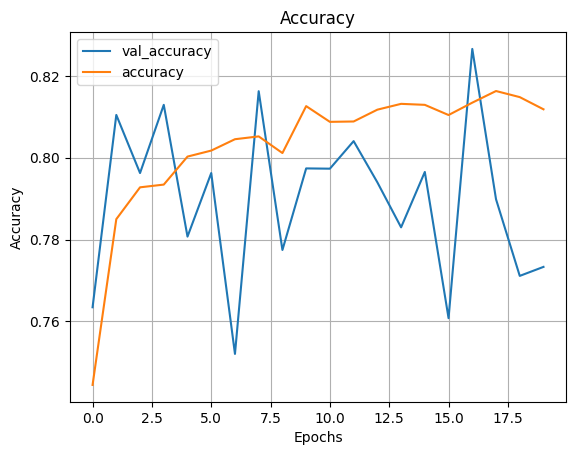

In [14]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.savefig(path + name +'acc.pdf')
plt.show()

In [24]:
from contextlib import redirect_stdout
import json


with open(path + name + '.txt', 'w') as f:
    with redirect_stdout(f):
        softmax.summary()
    f.write('\n')
    f.write('Loss: ' + softmax.loss)
    f.write('\n\n')
    f.write('Optimizer:\n')
    for key, value in softmax.optimizer.get_config().items(): 
        f.write('%s:%s\n' % (key, value))
    f.write('\n')
    f.write('f1 macro: ')
    f.write(str(f1Macro))
    f.write('\n')
    f.write('auc: ')
    f.write(str(areaROC))
    f.write('\n')
    f.write('acc: ')
    f.write(str(history.history['val_accuracy'][-1]))
    f.write('\n')
    f.write('loss: ')
    f.write(str(history.history['val_loss'][-1]))
    f.write('\n')
    f.write('precision: ')
    f.write(str(history.history['val_precision_1'][-1]))
    f.write('\n')
    f.write('recall: ')
    f.write(str(history.history['val_recall_1'][-1]))


NameError: name 'path' is not defined

In [11]:
from tensorflow.keras.layers import LeakyReLU, Dropout



act = 'relu'

modelMLP = Sequential()
modelMLP.add(Flatten(input_shape=(28, 28)))
modelMLP.add(Dropout(0.3))
modelMLP.add(BatchNormalization(synchronized=True))
modelMLP.add(Dense(1000, activation=act, kernel_initializer=GlorotNormal(seed=1)))#LeakyReLU(alpha=0.05)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) ))
modelMLP.add(Dropout(0.3))
modelMLP.add(BatchNormalization(synchronized=True))
modelMLP.add(Dense(1000, activation=act, kernel_initializer=GlorotNormal(seed=1)))#LeakyReLU(alpha=0.05)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) ))
modelMLP.add(Dropout(0.3))
modelMLP.add(BatchNormalization(synchronized=True))
modelMLP.add(Dense(1000, activation=act, kernel_initializer=GlorotNormal(seed=1)))#LeakyReLU(alpha=0.05)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) ))
modelMLP.add(Dropout(0.3))
modelMLP.add(BatchNormalization(synchronized=True))
modelMLP.add(Dense(2, activation='linear'))
modelMLP.add(Dense(10, activation='softmax', kernel_initializer=GlorotNormal(seed=1)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
modelMLP.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1000)              785000    
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1000)             4000      
 hNormalization)                                      

In [26]:
stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

batch = 256
#dropout = 0.3
#dropouts = np.arange(0.1, 0.6, 0.1)
#activaciones = ['tanh', 'relu', 'elu', LeakyReLU(alpha=0.3)]
act = 'relu'

#optimizers = [SGD(learning_rate=0.002), Adagrad(learning_rate=0.002), Adam(learning_rate=0.002), Nadam(learning_rate=0.002), Adamax(learning_rate=0.002)]
#opt = Adamax(learning_rate=0.002)

#inits = [GlorotNormal(seed=1), glorot_uniform(), zeros(), random_normal(mean=0., stddev=1.), constant(3.)]

#lrs = np.arange(0.002, 0.022, 0.002)
'''
for dropout in dropouts:
    #name = act if type(act) == str else 'leaky relu'
    name = str(dropout)
    print(name)
    modelMLP = Sequential()
    modelMLP.add(Flatten(input_shape=(28, 28)))
    modelMLP.add(Dropout(dropout))
    modelMLP.add(BatchNormalization(synchronized=True))
    modelMLP.add(Dense(1000, activation=act))#LeakyReLU(alpha=0.05)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) ))
    modelMLP.add(Dropout(dropout))
    modelMLP.add(BatchNormalization(synchronized=True))
    modelMLP.add(Dense(1000, activation=act))#LeakyReLU(alpha=0.05)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) ))
    modelMLP.add(Dropout(dropout))
    modelMLP.add(BatchNormalization(synchronized=True))
    modelMLP.add(Dense(1000, activation=act))#LeakyReLU(alpha=0.05)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) ))
    modelMLP.add(Dropout(dropout))
    modelMLP.add(BatchNormalization(synchronized=True))
    #modelMLP.add(Dense(2, activation='linear'))
    modelMLP.add(Dense(10, activation='softmax'))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), kernel_initializer=init))
'''
modelMLP.compile(loss="categorical_crossentropy", optimizer=Adamax(learning_rate=0.002), metrics=["accuracy", Precision(), Recall()])

history2 = modelMLP.fit(x = trainX, y = sparseTrainY, validation_data = (testX, sparseTestY), epochs = 160, batch_size = batch, callbacks=[stop], verbose=1)
'''   
    with open('VarHyper2/dropouts.txt', 'a') as f:
        f.write(str(history2.history['val_accuracy'][-1]))
        f.write(', ')
        f.write(str(np.argmax(history2.history['val_accuracy'])))
        f.write(', ')
        f.write(name)
        f.write('\n')
'''

Epoch 1/160
176/176 [==============================] - 20s 103ms/step - loss: 1.4133 - accuracy: 0.4893 - precision_1: 0.8553 - recall_1: 0.3792 - val_loss: 1.1787 - val_accuracy: 0.5450 - val_precision_1: 0.9230 - val_recall_1: 0.4235
Epoch 2/160
176/176 [==============================] - 18s 104ms/step - loss: 1.0310 - accuracy: 0.6531 - precision_1: 0.8951 - recall_1: 0.4876 - val_loss: 0.8263 - val_accuracy: 0.7633 - val_precision_1: 0.9196 - val_recall_1: 0.6121
Epoch 3/160
176/176 [==============================] - 18s 101ms/step - loss: 0.8375 - accuracy: 0.7398 - precision_1: 0.9006 - recall_1: 0.6068 - val_loss: 0.7163 - val_accuracy: 0.7805 - val_precision_1: 0.9178 - val_recall_1: 0.6411
Epoch 4/160
176/176 [==============================] - 18s 101ms/step - loss: 0.7427 - accuracy: 0.7772 - precision_1: 0.9057 - recall_1: 0.6263 - val_loss: 0.6358 - val_accuracy: 0.8143 - val_precision_1: 0.9194 - val_recall_1: 0.6643
Epoch 5/160
176/176 [==============================] - 1

"   \n    with open('VarHyper2/dropouts.txt', 'a') as f:\n        f.write(str(history2.history['val_accuracy'][-1]))\n        f.write(', ')\n        f.write(str(np.argmax(history2.history['val_accuracy'])))\n        f.write(', ')\n        f.write(name)\n        f.write('\n')\n"

In [27]:
modelMLP.save('capa2.h5')

In [235]:
name2 = 'glorotNorm'
predict2 = modelMLP.predict(testX)
argmaxPredict2 = np.argmax(predict2, axis=1)
f1Macro2 = f1_score(testY, argmaxPredict2, average='macro')
f1Macro2

469/469 [==============================] - 4s 9ms/step


0.9039133752070413

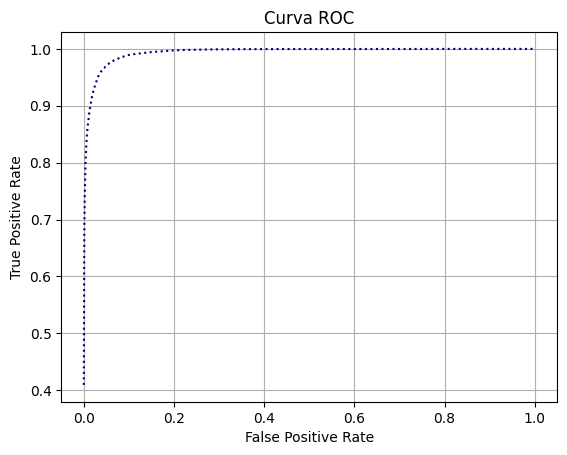

In [236]:
fpr2, tpr2, roc_auc2 = dict(), dict(), dict()

label_binarizer2 = LabelBinarizer().fit(trainY)
y_onehot_test2 = label_binarizer2.transform(testY)
n_classes = 10

for i in range(n_classes):
    fpr2[i], tpr2[i], _ = roc_curve(y_onehot_test2[:, i], predict2[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

fpr_grid2 = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr2 = np.zeros_like(fpr_grid2)

for i in range(n_classes):
    mean_tpr2 += np.interp(fpr_grid2, fpr2[i], tpr2[i])  # linear interpolation

# Average it and compute AUC
mean_tpr2 /= n_classes

fpr2["macro"] = fpr_grid2
tpr2["macro"] = mean_tpr2
roc_auc2["macro"] = auc(fpr2["macro"], tpr2["macro"])

#print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

plt.plot(
    fpr2["macro"],
    tpr2["macro"],
    color='navy',
    linestyle=':'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.grid()


path2 = 'Modelos/MLP/'


plt.savefig(path2 + name2 +'.pdf')
plt.show()

In [237]:
areaROC2 = roc_auc_score(testY, predict2, multi_class='ovr', average='macro')
areaROC2

0.9937907051470882

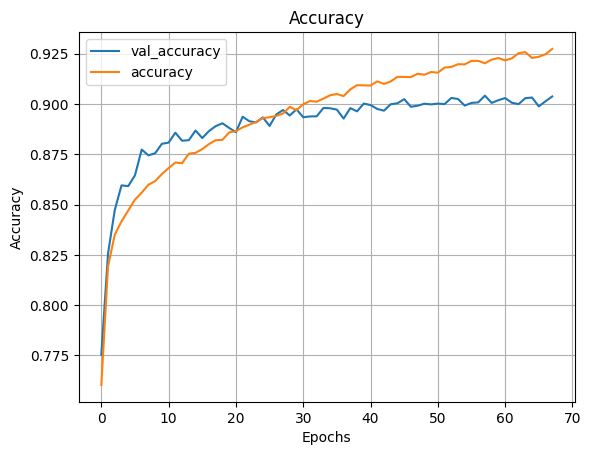

In [238]:
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.plot(history2.history['accuracy'], label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.savefig(path2 + name2 +'acc.pdf')
plt.show()

In [239]:
with open(path2 + name2 + '.txt', 'w') as f:
    with redirect_stdout(f):
        modelMLP.summary()
    f.write('\n')
    f.write('Loss: ' + modelMLP.loss)
    f.write('\n\n')
    f.write('Optimizer:\n')
    for key, value in modelMLP.optimizer.get_config().items(): 
        f.write('%s:%s\n' % (key, value))
    f.write('\n')
    f.write('f1 macro: ')
    f.write(str(f1Macro2))
    f.write('\n')
    f.write('auc: ')
    f.write(str(areaROC2))
    f.write('\n')
    f.write('acc: ')
    f.write(str(history2.history['val_accuracy'][-1]))
    f.write('\n')
    f.write('loss: ')
    f.write(str(history2.history['val_loss'][-1]))
    f.write('\n')
    f.write('precision: ')
    f.write(str(history2.history['val_precision_104'][-1]))
    f.write('\n')
    f.write('recall: ')
    f.write(str(history2.history['val_recall_104'][-1]))
    f.write('\n')
    f.write('Activation: ')
    f.write(act)
    f.write('\n')
    f.write('Batch: ')
    f.write(str(batch))



In [234]:
submission = pd.DataFrame()
data = np.load('Data/test_images.npy')/255
submission['id'] = np.arange(len(data))
submission['Category'] = np.argmax(modelMLP.predict(data), (1))
submission.to_csv('submission.csv', index=False)

313/313 [==============================] - 3s 9ms/step


In [13]:
capa2 = load_model('capa2.h5')

modelc2 = Sequential()
modelc2.add(Flatten(input_shape=(28, 28)))
modelc2.add(Dropout(0.3))
modelc2.add(BatchNormalization(synchronized=True))
modelc2.add(Dense(1000, activation=act, kernel_initializer=GlorotNormal(seed=1)))#LeakyReLU(alpha=0.05)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) ))
modelc2.add(Dropout(0.3))
modelc2.add(BatchNormalization(synchronized=True))
modelc2.add(Dense(1000, activation=act, kernel_initializer=GlorotNormal(seed=1)))#LeakyReLU(alpha=0.05)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) ))
modelc2.add(Dropout(0.3))
modelc2.add(BatchNormalization(synchronized=True))
modelc2.add(Dense(1000, activation=act, kernel_initializer=GlorotNormal(seed=1)))#LeakyReLU(alpha=0.05)))#, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001) ))
modelc2.add(Dropout(0.3))
modelc2.add(BatchNormalization(synchronized=True))
modelc2.add(Dense(2, activation='linear'))
modelc2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dropout_8 (Dropout)         (None, 784)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 1000)              785000    
                                                                 
 dropout_9 (Dropout)         (None, 1000)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 1000)             4000      
 hNormalization)                                      

In [14]:
for layer, layer2 in zip(modelc2.layers, capa2.layers):
    layer.set_weights(layer2.get_weights())
    


In [15]:
modelc2.compile(loss="categorical_crossentropy", optimizer=Adamax(learning_rate=0.002), metrics=["accuracy", Precision(), Recall()])

In [16]:
outputc2 = modelc2.predict(data)

1875/1875 [==============================] - 14s 7ms/step


In [17]:

#plt.scatter(output[labelsNp==4, 0], output[labelsNp==4, 1], alpha = 0.1)
#plt.xlim(-200, 200)    
#plt.ylim(-200, 200)    
#plt.show()

In [18]:
from keras.models import Model
from keras.layers import Input

modelout = Sequential()

modelout.add(Input(shape=(2,)))
modelout.add(Dense(10, activation='softmax'))

modelout.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 10)                30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [19]:
modelout.compile(loss="categorical_crossentropy", optimizer=Adamax(learning_rate=0.002), metrics=["accuracy", Precision(), Recall()])

In [20]:
modelout.layers[0].set_weights(capa2.layers[-1].get_weights()) 

In [27]:
range_nums = np.arange(-30000, 30000, 100)

# Create the meshgrid
x, y = np.meshgrid(range_nums, range_nums)

# Combine x and y into a 2D array
combinations = np.column_stack((x.flatten(), y.flatten()))

# Print the shape and the first few rows of the array

In [28]:
outputOut = modelout.predict(combinations)

11250/11250 [==============================] - 16s 1ms/step


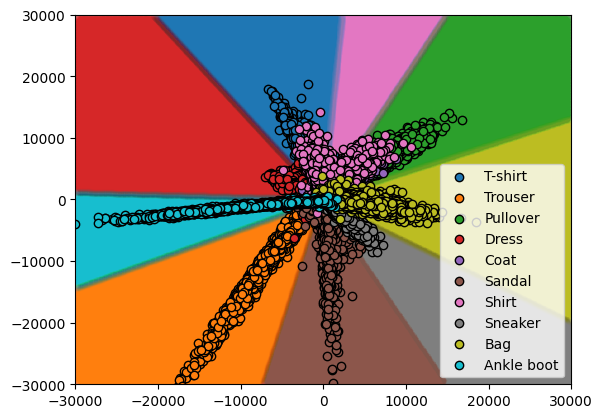

In [34]:


argm = np.zeros(len(outputOut))

for idx, val in enumerate(outputOut):
    argm[idx] = int(np.argmax(val))
    
for i in range(10):
    plt.scatter(combinations[argm==i, 0], combinations[argm==i, 1], alpha=0.01)
    #print(combinations[argm==i, 0], combinations[argm==i, 1])
    
for i in range(10):
    #if i != 4:
    plt.scatter(outputc2[labelsNp==i, 0], outputc2[labelsNp==i, 1], alpha = 1, edgecolors='black', label=clases[i])

plt.xlim(-30000, 30000)    
plt.ylim(-30000, 30000) 
plt.legend()
    
plt.show()           

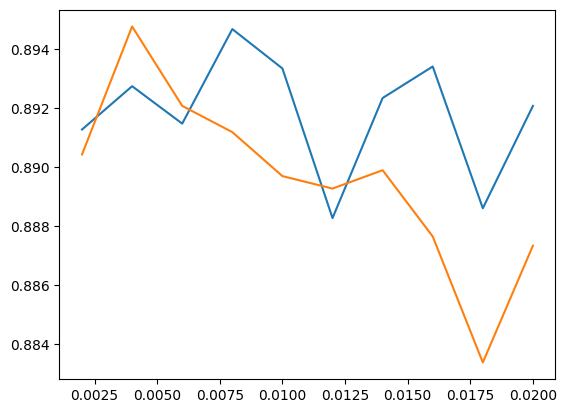

In [168]:
learn = np.loadtxt('VarHyper/lr.txt', delimiter=',')
plt.plot(learn[:, 2], learn[:, 0], learn[:, 2], learn[:, 1])
plt.show()

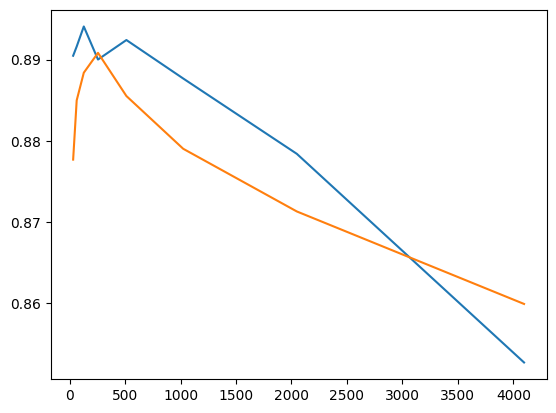

In [169]:
learn = np.loadtxt('VarHyper/batchsize.txt', delimiter=',')
plt.plot(learn[:, 2], learn[:, 0], learn[:, 2], learn[:, 1])
plt.show()

In [9]:
model1 = load_model('Red1.h5')

In [10]:
pred =  model1.predict(testX)

469/469 [==============================] - 4s 7ms/step


In [11]:
import tensorflow as tf

argmx = [np.argmax(p) for p in pred]    
arr = np.array(argmx)


m = tf.keras.metrics.Accuracy()
m.update_state(arr, testY)
m.result().numpy()


0.09593333

In [12]:
model2 = load_model('Red2.h5')

In [13]:
pred2 =  model2.predict(testX)

469/469 [==============================] - 4s 8ms/step


In [14]:
argmx2 = [np.argmax(p) for p in pred2]    
arr2 = np.array(argmx2)


n = tf.keras.metrics.Accuracy()
n.update_state(arr2, testY)
n.result().numpy()

0.89433336

In [15]:
 model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dropout_16 (Dropout)        (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 1000)              785000    
                                                                 
 dropout_17 (Dropout)        (None, 1000)              0         
                                                                 
 dense_17 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_18 (Dropout)        (None, 1000)              0         
                                                                 
 dense_18 (Dense)            (None, 1000)             

In [16]:
model1.layers[8].get_weights()[1].shape

(10,)

In [18]:
model3 = load_model('Red1.h5')

In [19]:
from helper import elim50



for idx, layer in enumerate(model3.layers):

    if not idx%2 and idx:
        bshape = model1.layers[idx].get_weights()[1].shape
        if idx != 8:
            layer.set_weights([elim50(model1.layers[idx].get_weights()[0], model2.layers[idx].get_weights()[0]), np.zeros(bshape)])


In [20]:
pred3 = model3.predict(testX)

469/469 [==============================] - 3s 7ms/step


In [21]:
#model3.layers[2].get_weights()[0]

In [22]:
argmx3 = [np.argmax(p) for p in pred3]    
arr3 = np.array(argmx3)


o = tf.keras.metrics.Accuracy()
o.update_state(arr3, testY)
o.result().numpy()

0.1198